In [1]:
import json
import os
import seaborn as sns
import re

In [2]:
import pandas as pd
import numpy as np
from pandas.io.json import json_normalize

In [3]:
res_df = pd.read_pickle("../data/output/run_full.pkl")

In [4]:
def highlight_max(data, color='yellow'):
    '''
    highlight the maximum in a Series or DataFrame
    '''
    attr = 'background-color: {}'.format(color)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_max = data == data.max()
        return [attr if v else '' for v in is_max]
    else:  # from .apply(axis=None)
        is_max = data == data.max().max()
        return pd.DataFrame(np.where(is_max, attr, ''),
                            index=data.index, columns=data.columns)

In [5]:
res_df.rename(columns = lambda x: x.replace(".", "_"), inplace=True)
res_df['method_name'] = res_df['method'].apply(lambda x: x.split("_")[0])
res_df['method_name_full'] = res_df['method_name'] + '_' + res_df['method_nn_stability'].astype(str) + '_' + res_df['run']
res_df = res_df.fillna(0)

In [6]:
res_df.columns

Index(['method', 'quality_metrics_kappa', 'result_C', 'result_gamma',
       'result_metrics_kappa', 'result_metrics_f1', 'data_file',
       'data_set_name', 'log_dir', 'method_C_steps', 'method_adjusted',
       'method_initial_n', 'method_max_gamma', 'method_max_iteration',
       'method_n_samples', 'method_nn_stability', 'method_stability_threshold',
       'method_stability_window', 'oracle', 'output_file',
       'quality_metrics_f1', 'seed', 'selection_metric', 'solver_args',
       'solver_constructor', 'solver_kwargs_OutputFlag',
       'solver_kwargs_Threads', 'run', 'method_C_Strategy', 'method_C_range',
       'method_gamma_range', 'method_gamma_strategy', 'method_init_strategy',
       'method_k', 'method_p', 'method_η', 'method_name', 'method_name_full'],
      dtype='object')

In [7]:
res_df.query('method.str.contains("Wang")')['method_init_strategy'][1]

'KernelLearning.WangCombinedStrategy(JuMP.OptimizerFactory(Gurobi.Optimizer, (), Base.Iterators.Pairs(:OutputFlag=>0,:Threads=>1)), [0.794328, 1.02453, 1.32146, 1.70443, 2.19839, 2.83551, 3.65728, 4.7172, 6.0843, 7.8476, 10.1219, 13.0554, 16.839, 21.7191, 28.0136, 36.1322, 46.6038, 60.1101, 77.5307, 100.0], 0.001:0.005210526315789474:0.1, SVDD.f1_scoring)'

In [8]:
res_df['method_name_full'].unique()

array(['ALKernel_10.0_AL', 'ALKernel_1.0_AL', 'ALKernel_5.0_AL',
       'ALRandom_10.0_AL', 'ALRandom_1.0_AL', 'ALRandom_5.0_AL',
       'DFNHeuristic-FixedCStrategy_nan_Competitors',
       'DFNHeuristic-RandomSampleGrid_nan_Competitors',
       'QMSHeuristic(0, 0.05, 0.0)_nan_Competitors',
       'SupervisedGridSearch_nan_Competitors',
       'WangHeuristic_nan_Competitors'], dtype=object)

In [9]:
def clean_name(x):
    res = x['method_name']
    if "Wang" in res:
        if "[0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]" in x['method_init_strategy']:
            res = "ADS-default"
        else:
            res = "ADS-ext"
    if res == "ALRandom":
        res = "AL-Rand"
    if res == "ALKernel":
        res = "AL-MMA"
    if res == "DFNHeuristic-FixedCStrategy":
        res = "DFN-Fix"
    if res == "DFNHeuristic-RandomSampleGrid":
        res = "DFN-Rand"
    if "QMSHeuristic" in res:
        res = "QMS"
    if res == "SupervisedGridSearch":
        res = "S-Grid"
    return res

In [10]:
res_df['method_name'] = res_df.apply(lambda x: clean_name(x), axis=1)

In [11]:
res_df['method_name'].unique()

array(['AL-MMA', 'AL-Rand', 'DFN-Fix', 'DFN-Rand', 'QMS', 'S-Grid',
       'ADS-default', 'ADS-ext'], dtype=object)

In [12]:
tmp = res_df.query('method_name == "SupervisedGridSearch" or (method_stability_threshold < 0.0001 and (method_nn_stability == 5 or method_nn_stability == 0))')[['data_set_name', 'method_name', 'result_metrics_kappa', 'result_metrics_f1', 'result_gamma']]

In [13]:
tmp = tmp.groupby(['data_set_name', 'method_name'])

In [14]:
kappa_out = tmp.agg({'result_metrics_kappa': 'mean'}).reset_index().pivot(index='data_set_name', columns = 'method_name', values = 'result_metrics_kappa')

In [15]:
# Filter data sets where none of the methods produces useful results
kappa_out = kappa_out.query('data_set_name != "PenDigits" and data_set_name != "Parkinson"')

In [16]:
kappa_out = kappa_out[['AL-MMA', 'AL-Rand', 'DFN-Fix', 'DFN-Rand', 'QMS', 'ADS-default', 'ADS-ext', 'S-Grid']] 

In [17]:
kappa_out.drop('S-Grid', axis = 1).style.apply(highlight_max, axis=1)

method_name,AL-MMA,AL-Rand,DFN-Fix,DFN-Rand,QMS,ADS-default,ADS-ext
data_set_name,,,,,,,
Annthyroid,0.0199797,0.0250814,0,0.00477027,0,0,0.0277358
Cardiotocography,0.251577,0.233347,0,0.232137,nan,0,0.151263
Glass,0.152985,0.0901523,0.0376874,0,nan,0.108068,0
HeartDisease,0.126159,0.100154,0,0,0,0.11704,0
Hepatitis,0.0480702,0.149521,0,0,0,0,0
Ionosphere,0.66229,0.657988,0,0,nan,0.585468,0
Lymphography,0.470761,0.410358,0.47331,0,nan,0.158028,0
PageBlocks,0.416286,0.352151,0.096599,0.181336,0,0,0.194524
Pima,0.0836274,0.162971,0.0159327,0,0,0.0502827,0


In [18]:
kappa_out

method_name,AL-MMA,AL-Rand,DFN-Fix,DFN-Rand,QMS,ADS-default,ADS-ext,S-Grid
data_set_name,,,,,,,,
Annthyroid,0.019980,0.025081,0.000000,0.004770,0.000000,0.000000,0.027736,0.038334
Cardiotocography,0.251577,0.233347,0.000000,0.232137,NaN,0.000000,0.151263,0.244155
Glass,0.152985,0.090152,0.037687,0.000000,NaN,0.108068,0.000000,0.247583
HeartDisease,0.126159,0.100154,0.000000,0.000000,0.000000,0.117040,0.000000,0.134615
Hepatitis,0.048070,0.149521,0.000000,0.000000,0.000000,0.000000,0.000000,0.205448
Ionosphere,0.662290,0.657988,0.000000,0.000000,NaN,0.585468,0.000000,0.784250
Lymphography,0.470761,0.410358,0.473310,0.000000,NaN,0.158028,0.000000,0.509470
PageBlocks,0.416286,0.352151,0.096599,0.181336,0.000000,0.000000,0.194524,0.517560
Pima,0.083627,0.162971,0.015933,0.000000,0.000000,0.050283,0.000000,0.140847


In [19]:
with open("tables/kappa_table.tex", "w") as f:
    f.write(kappa_out.to_latex(index=True, float_format="{:0.2f}".format).replace('nan', ' --'))

In [20]:
gamma_out = tmp.agg({'result_gamma': 'mean'}).reset_index().pivot(index='data_set_name', columns = 'method_name', values = 'result_gamma')

In [21]:
gamma_out

method_name,ADS-default,ADS-ext,AL-MMA,AL-Rand,DFN-Fix,DFN-Rand,QMS,S-Grid
data_set_name,,,,,,,,
Annthyroid,10.0000,16.838980,2.860570,12.366377,1.757178,1.757178,10.223681,2.835513
Cardiotocography,10.0000,7.847600,2.771524,3.640926,1.415562,1.415562,NaN,0.794328
Glass,10.0000,21.719114,20.194110,29.834425,2.295998,2.295998,NaN,60.110089
HeartDisease,1.0000,0.794328,1.292853,1.002003,0.813062,0.813062,1.262854,1.024534
Hepatitis,0.0001,0.794328,6.998004,0.291746,0.621124,0.621124,0.761097,1.024534
Ionosphere,1.0000,1.321456,0.850199,1.394347,0.713062,0.713062,NaN,3.657277
Lymphography,0.0001,0.794328,2.006048,2.906823,4.145363,4.145363,NaN,1.704429
PageBlocks,100.0000,100.000000,8.083196,78.287179,2.344716,2.344716,50.304445,1.024534
Parkinson,1.0000,1.704429,2.268579,2.463233,0.813062,0.813062,1.856456,28.013568


#### Number of observations vs nn_stability

In [22]:
kappa_df = pd.read_pickle("../data/output/run_kappa.pkl")
kappa_df.rename(columns = lambda x: x.replace(".", "_"), inplace=True)

In [23]:
data_name = "Ionosphere"

In [24]:
tmp_kappa = kappa_df.query('data_set_name == @data_name')[['result_metrics_kappa', 'result_gamma', 'method_nn_stability', 'result_C']].sort_values(['method_nn_stability'])

In [25]:
tmp_kappa = tmp_kappa.groupby(["method_nn_stability"]).mean().reset_index()

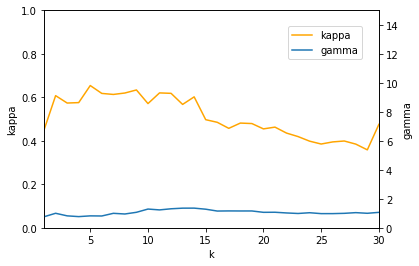

In [26]:
ax1 = tmp_kappa.plot(x="method_nn_stability", y="result_metrics_kappa", legend=False, color="orange")
ax1.set_ylabel("kappa")
ax1.set_xlabel("k")
ax1.set_ylim([0,1])
ax2 = ax1.twinx()
ax2.set_ylabel("gamma")
ax2.set_ylim([0,15])
tmp_kappa.plot(x="method_nn_stability", y="result_gamma", ax = ax2,legend=False)
ax1.figure.legend(loc="upper right", bbox_to_anchor=(0.85, 0.85), labels = ["kappa", "gamma"])
# sns.lineplot(x = tmp_kappa['method_nn_stability'], y = tmp_kappa['result_metrics_kappa'])

In [27]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 20}
matplotlib.rc('font', **font)
matplotlib.rcParams['xtick.major.pad']='8'
matplotlib.rcParams['ytick.major.pad']='8'

In [28]:
def plot_kappa(data_name, add_legend=True):
    tmp_kappa = kappa_df.query('data_set_name == @data_name')[['result_metrics_kappa', 'result_gamma', 'method_nn_stability', 'result_C']].sort_values(['method_nn_stability'])
    tmp_kappa = tmp_kappa.groupby(["method_nn_stability"]).mean().reset_index()

    ax1 = tmp_kappa.plot(x="method_nn_stability", y="result_metrics_kappa", legend=False, color="orange", linewidth=4)
    ax1.set_ylabel("kappa")
    ax1.set_xlabel("k")
    ax1.set_ylim([0,1])
    ax2 = ax1.twinx()
    ax2.set_ylabel("gamma")
    ax2.set_ylim([0,15])
    tmp_kappa.plot(x="method_nn_stability", y="result_gamma", ax = ax2,legend=False, linewidth=4)
    ax1.set_title(data_name)

    if add_legend:
        ax1.figure.legend(loc="upper right", bbox_to_anchor=(0.8, 0.83), labels = ["kappa", "gamma"])
    return ax1.get_figure()

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


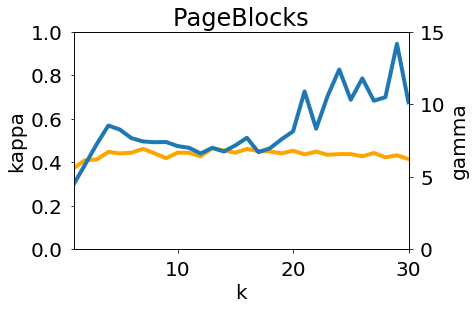

In [29]:
plt1 = plot_kappa("PageBlocks", add_legend=False)

In [30]:
plt1.set_size_inches(7, 5)
plt1.tight_layout()
plt1.savefig("plots/kappa_pageblocks.pdf")

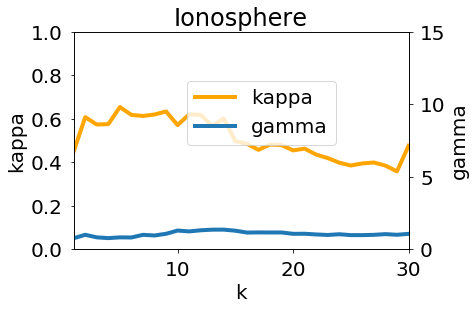

In [31]:
plt2 = plot_kappa("Ionosphere", add_legend=True)

In [32]:
plt2.set_size_inches(7, 5)
plt2.tight_layout()
plt2.savefig("plots/kappa_ionosphere.pdf")